In [1]:
import os
os.chdir('/home/victorhuang/projects/gtx')

import numpy as np
import mat73
import scipy.io as sio
import matplotlib.pyplot as plt

# Spatial frequency
fx = [0, 0.05, 0.1, 0.15, 0.2, 0.25] 

def load_data_dt(file_path):
    data = sio.loadmat(file_path)
    
    data = {k: v for k, v in data.items() if not k.startswith('__')}

    return data

all_data = load_data_dt('data/20241118_data_splited.mat')

test_data = {
    'fluorescence': all_data['test_fluorescence'],
    'optical_props': all_data['test_optical_props'],
    'reflectance': all_data['test_reflectance'],
    'depth': all_data['test_depth'],
    'concentration': all_data['test_concentration_fluor']
}


# Stats

In [2]:
mu_a = test_data['optical_props'][15, :, :, 0]
mu_sp = test_data['optical_props'][15, :, :, 1]

min_mu_a = np.min(mu_a)
min_mu_sp = np.min(mu_sp)

max_mu_a = np.max(mu_a)
max_mu_sp = np.max(mu_sp)

mean_mu_a = np.mean(mu_a)
mean_mu_sp = np.mean(mu_sp)

print(f'min_mu_a: {min_mu_a}, min_mu_sp: {min_mu_sp}')
print(f'max_mu_a: {max_mu_a}, max_mu_sp: {max_mu_sp}')
print(f'mean_mu_a: {mean_mu_a}, mean_mu_sp: {mean_mu_sp}')

min_mu_a: 0.0019565934780985117, min_mu_sp: 0.9638652205467224
max_mu_a: 0.003472569165751338, max_mu_sp: 1.0074886083602905
mean_mu_a: 0.0026486648712307215, mean_mu_sp: 0.9835740923881531


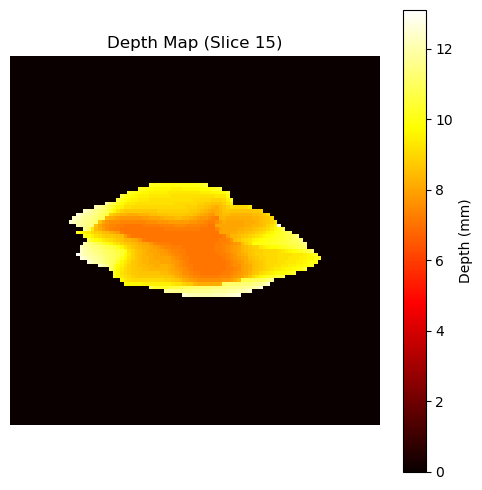

In [3]:
# max_depth = -np.inf
# for i in range(36):
#     depth = test_data['depth'][i]
#     depth_m = np.max(depth)
#     if depth_m > max_depth:
#         max_depth = depth_m
#         max_depth_idx = i

t = test_data['depth'][15]

plt.figure(figsize=(5, 5))
plt.imshow(t, cmap='hot', interpolation='nearest')
plt.title(f"Depth Map (Slice {15})")
plt.colorbar(label='Depth (mm)')
plt.axis('off')
plt.tight_layout()
plt.show()

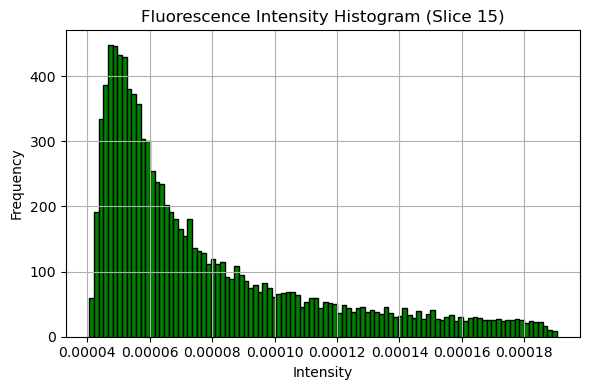

In [4]:
def histogram(data, idx):
    d = data['fluorescence'][idx][:,:,0] # this is shape (101,101)
    pixels = d.ravel()

    plt.figure(figsize=(6, 4))
    plt.hist(pixels, bins=100, color='green', edgecolor='black')
    plt.title(f"Fluorescence Intensity Histogram (Slice {idx})")
    plt.xlabel("Intensity")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

histogram(test_data, 15)

# Modulation amplitude normalization

In [5]:
# normalization against f(0) given one sample
def normalization(F):
    F0 = F[:, :, 0]
    return F / (F0[:, :, np.newaxis] + 1e-20)

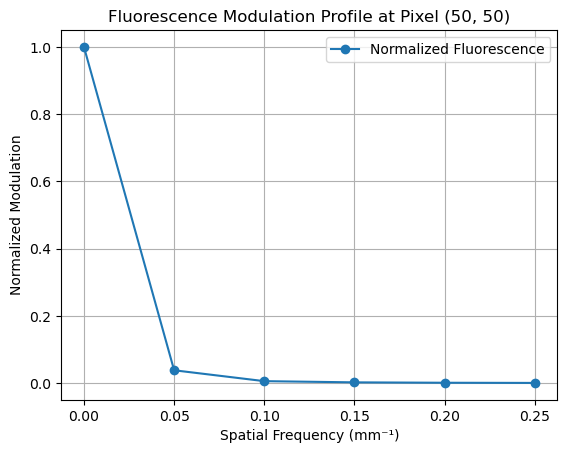

In [6]:
def plot_modulation_curve(x, y, f_norm):
    mf_curve = f_norm[y, x, :]
    plt.plot(fx, mf_curve, 'o-', label='Normalized Fluorescence')
    plt.xlabel('Spatial Frequency (mm⁻¹)')
    plt.ylabel('Normalized Modulation')
    plt.title('Fluorescence Modulation Profile at Pixel (50, 50)')
    plt.grid(True)
    plt.legend()
    plt.show()

s0 = test_data['fluorescence'][15]
s0_norm = normalization(s0)
plot_modulation_curve(50, 50, s0_norm)

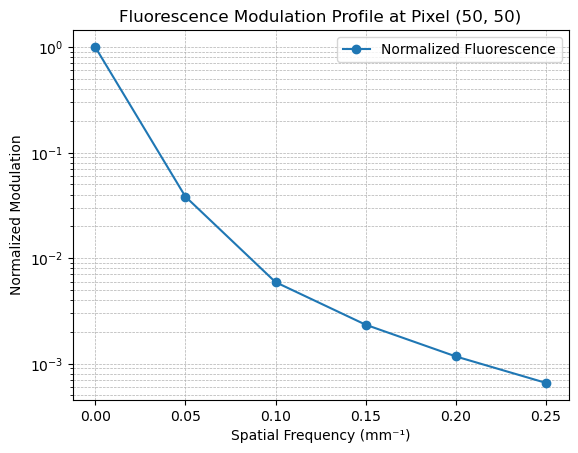

In [52]:
def plot_modulation_curve(x, y, f_norm):
    mf_curve = f_norm[y, x, :]
    plt.plot(fx, mf_curve, 'o-', label='Normalized Fluorescence')
    plt.xlabel('Spatial Frequency (mm⁻¹)')
    plt.ylabel('Normalized Modulation')
    plt.title(f'Fluorescence Modulation Profile at Pixel ({x}, {y})')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

s0 = test_data['fluorescence'][15]
s0_norm = normalization(s0)
plot_modulation_curve(50, 50, s0_norm)

# LUT generation using greens function

In [7]:
def compute_k(mu_a, mu_sp, fx):
    fx = np.array(fx)
    k = np.sqrt(3 * mu_a * (mu_a + mu_sp + (4 * np.pi**2 * fx**2 / 3)))
    return k

def generate_LUT(fx, depth, mu_a, mu_sp):
    k_fx = compute_k(mu_a, mu_sp, fx)
    lut = {}

    for z in depth:
        phi = np.exp(-k_fx * z)
        phi /= phi[0]
        lut[z] = phi

    return lut

def generate_LUT_emperical(fx, depth, alpha=6):
    fx = np.array(fx)
    lut = {}
    for z in depth:
        curve = np.exp(-alpha * fx * z)
        curve /= curve[0]
        lut[z] = curve
    return lut

# Depth estimation

In [8]:
def fit_depth_from_curve(measured_curve, lut):
    min_error = np.inf
    best_depth = None

    for z, pred_curve in lut.items():
        error = np.sum((measured_curve - pred_curve) ** 2)
        if error < min_error:
            min_error = error
            best_depth = z

    return best_depth

In [48]:
def estimate_depth(sample_idx, data):
    depth_mm = np.linspace(0.5, 15, 200)

    F = data['fluorescence'][sample_idx]
    F_norm = normalization(F)
    
    mu_a_map = data['optical_props'][sample_idx, :, :, 0]
    mu_sp_map = data['optical_props'][sample_idx, :, :, 1]

    depth_map = np.zeros((mu_a_map.shape[0], mu_a_map.shape[1]))

    for y in range(mu_a_map.shape[0]):
        for x in range(mu_a_map.shape[1]):
            mu_a = mu_a_map[y, x]
            mu_sp = mu_sp_map[y, x]
            norm_curve = F_norm[y, x, :]

            if np.any(np.isnan(norm_curve)) or np.mean(norm_curve) < 1e-3:
                depth_map[y, x] = np.nan
                continue

            # lut = generate_LUT(fx, depth_mm, mu_a, mu_sp)
            lut = generate_LUT_emperical(fx, depth_mm, alpha=9)
            best_depth = fit_depth_from_curve(norm_curve, lut)
            depth_map[y, x] = best_depth

    return depth_map    


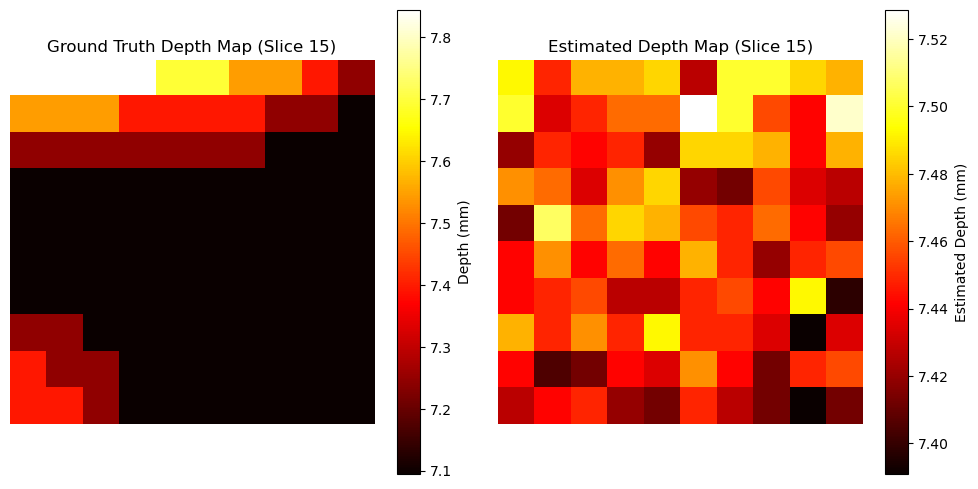

In [45]:
# x, y = 20,20

mu_a = test_data['optical_props'][15, 45:55, 45:55, 0]
mu_sp = test_data['optical_props'][15, 45:55, 45:55, 1]
fluorescence = test_data['fluorescence'][15, 45:55, 45:55, :]

f_norm = normalization(fluorescence)

depth_map = np.zeros((mu_a.shape[0], mu_a.shape[1]))

depth_mm = np.linspace(0.5, 15, 2000)

for y in range(mu_a.shape[0]):
    for x in range(mu_a.shape[1]):

        norm_curve = f_norm[y, x, :]

        if np.any(np.isnan(norm_curve)) or np.mean(norm_curve) < 1e-3:
            depth_map[y, x] = np.nan
            continue

            # lut = generate_LUT(fx, depth_mm, mu_a, mu_sp)
        lut = generate_LUT_emperical(fx, depth_mm, alpha=8.7)
        best_depth = fit_depth_from_curve(norm_curve, lut)
        depth_map[y, x] = best_depth


gt = test_data['depth'][15, 45:55, 45:55]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
im0 = axs[0].imshow(gt, cmap='hot', interpolation='nearest')
axs[0].set_title(f"Ground Truth Depth Map (Slice {15})")
axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], label='Depth (mm)')  # Correct colorbar

# Plot estimated depth
im1 = axs[1].imshow(depth_map, cmap='hot', interpolation='nearest')
axs[1].set_title(f"Estimated Depth Map (Slice {15})")
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], label='Estimated Depth (mm)')  # Correct colorbar

# Adjust layout
fig.tight_layout()
plt.show()

# Eval

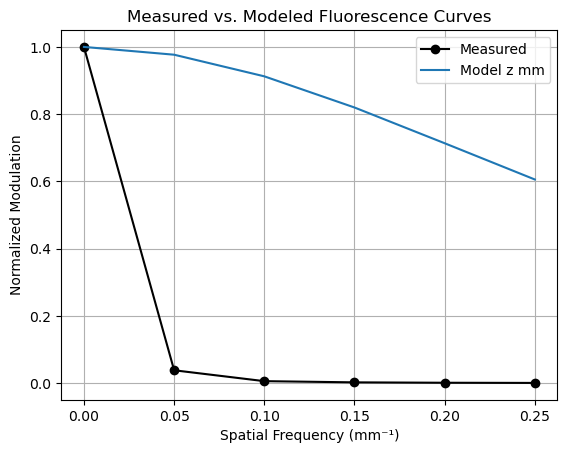

In [50]:
x, y = 5, 5
mu_a = test_data['optical_props'][15, 45:55, 45:55, 0]
mu_sp = test_data['optical_props'][15, 45:55, 45:55, 1]
fluorescence = test_data['fluorescence'][15, 45:55, 45:55, :]

roi = normalization(fluorescence)

mu_a = mu_a[y, x]
mu_sp = mu_sp[y, x]
norm_curve = f_norm[y, x, :]
depth_mm = np.linspace(0.5, 15, 200)
lut = generate_LUT(fx, depth_mm, mu_a, mu_sp)

# lut = generate_LUT_emperical(fx, depth_mm, alpha=9)

plt.plot(fx, norm_curve, 'ko-', label='Measured')

for z, curve in lut.items():
    if z in [1, 3, 5, 7, 9, 11, 13, 15]:
        plt.plot(fx, curve, label=f'Model z mm')

plt.xlabel('Spatial Frequency (mm⁻¹)')
plt.ylabel('Normalized Modulation')
plt.legend()
plt.title('Measured vs. Modeled Fluorescence Curves')
plt.grid(True)
plt.show()



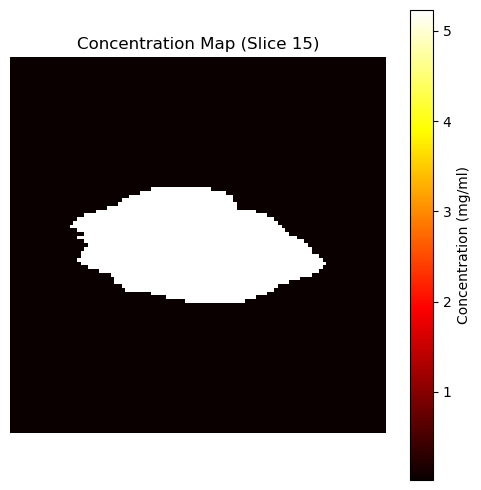

In [51]:
gt = test_data['concentration'][15]

plt.figure(figsize=(5, 5))
plt.imshow(gt, cmap='hot', interpolation='nearest')
plt.title(f"Concentration Map (Slice {15})")
plt.colorbar(label='Concentration (mg/ml)')
plt.axis('off')
plt.tight_layout()
plt.show()

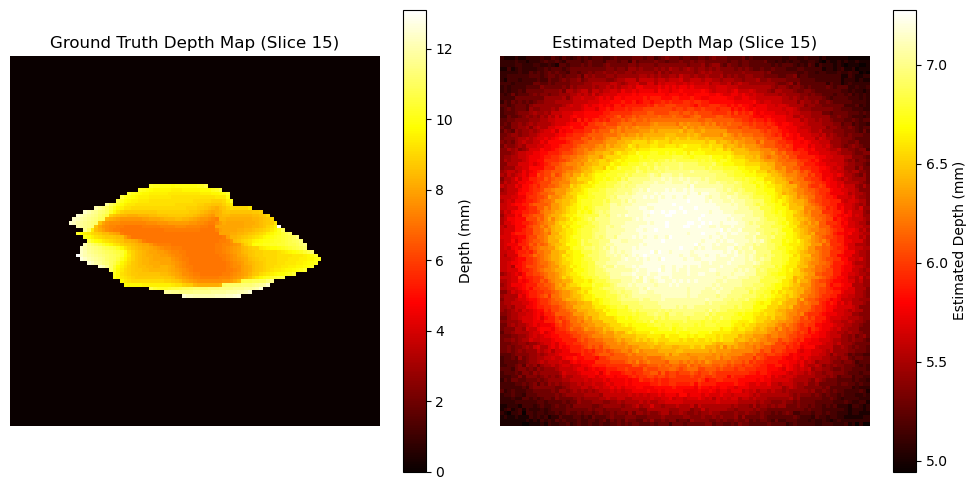

In [49]:
idx = 15
depth_map = estimate_depth(idx, test_data)
gt = test_data['depth'][idx]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
im0 = axs[0].imshow(gt, cmap='hot', interpolation='nearest')
axs[0].set_title(f"Ground Truth Depth Map (Slice {idx})")
axs[0].axis('off')
fig.colorbar(im0, ax=axs[0], label='Depth (mm)')  # Correct colorbar

# Plot estimated depth
im1 = axs[1].imshow(depth_map, cmap='hot', interpolation='nearest')
axs[1].set_title(f"Estimated Depth Map (Slice {idx})")
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1], label='Estimated Depth (mm)')  # Correct colorbar

# Adjust layout
fig.tight_layout()
plt.show()